In [31]:
import sys
sys.path.append("..")
import importlib
import numpy as np
import matplotlib.pyplot as plt
import qutip
import qutip.floquet as floq
import scipy as sp
import copy

import system.from_higher_basis_truncation_tunable_full_cosine as system
importlib.reload(system)
import utils.floquet_solver as fsolver
importlib.reload(fsolver)
import utils.floquetify as floqify
importlib.reload(floqify)
import utils.solver as solver
importlib.reload(solver)
import pulse.tanh as tanh
importlib.reload(tanh)
import utils.expectation_values as expect
importlib.reload(expect)
import utils.graph as graph
pass

In [49]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if np.amin(np.abs(array - value)) > 1e-12:
        print({
            "message": "error, duration does not exactly exist!",
            "value": value,
            "found_value": array[idx]
            })
    return idx

def overlap(state1, state2):
    return (np.transpose(np.matrix(state1.full())) * np.matrix(state2.full())).item()

def floquetify(system, solution, pulse, tlist):

    freq = pulse._wd

    # get times on peaks of drive
    dur_points = np.arange(0, np.amax(tlist), (2*np.pi)/(freq))
    dur_points = dur_points[1:-1]
    durations = tlist

    pulse_list = pulse.get_pulse(durations)
    num_of_points = 1110
    num_of_durPoints = 10
    plt.plot(durations[:num_of_points], pulse_list[:num_of_points])
    plt.scatter(dur_points[:num_of_durPoints], pulse.get_pulse(dur_points)[:num_of_durPoints])
    plt.show()

    # generate floquet kets
    kets = []
    energies = []
    for dur in dur_points:
        dur_amp = pulse.pulse_func(dur)
        def steady(t, args=None):
            return dur_amp * np.cos(freq * t)
        H = [system.H0, [system.H1, steady]]

        floquet_kets, quasi_energies = floq.floquet_modes(H, (2*np.pi)/freq)
        kets.append(floquet_kets)
        energies.append(quasi_energies)

    # sort floquet kets
    sorted_kets = [np.array(kets[0]).reshape((10,10))]
    sorted_energies = [np.array(energies[0])]
    for i in range(1, len(dur_points)):
        reshaped_ket = np.array(kets[i]).reshape((10,10))
        m = np.abs(np.dot( (sorted_kets[-1]), np.transpose(reshaped_ket)  ))**2
        row_ind, col_ind = sp.optimize.linear_sum_assignment(1-m)
        # print(col_ind)
        sorted_kets.append( reshaped_ket[col_ind] )
        sorted_energies.append( energies[i][col_ind] )

    # correctly order sorted kets
    expv_for_sorted_unordered_kets = []
    dur = dur_points[0]
    index_of_dur = find_nearest(durations, dur)
    ordered_energies = copy.deepcopy(sorted_energies)
    for k in sorted_kets[0]:
        expv_for_sorted_unordered_kets.append(qutip.expect(qutip.ket2dm(solution.states[index_of_dur]), qutip.Qobj(k)))
    for t in range(0, len(sorted_kets)):
        temp = []
        temp_energies = []
        for i in list(np.flip(np.argsort(expv_for_sorted_unordered_kets))):
            temp.append(sorted_kets[t][i])
            temp_energies.append(sorted_energies[t][i])
        sorted_kets[t] = temp
        ordered_energies[t] = temp_energies
    # sorted_kets = np.array(sorted_kets)[list(np.flip(np.argsort(expv_for_sorted_unordered_kets)))]


    # find overlaps of sorted kets
    overlaps = []
    expectation_values = []
    for i in range(len(dur_points)):
        ket = sorted_kets[i]
        dur = dur_points[i]
        index_of_dur = find_nearest(durations, dur)
        overlaps_at_this_dur = []
        expv_at_this_dur = [] 
        for k in ket:
            expv_at_this_dur.append(qutip.expect(qutip.ket2dm(solution.states[index_of_dur]), qutip.Qobj(k)))
            overlaps_at_this_dur.append(overlap(solution.states[index_of_dur], qutip.Qobj(k)))
        overlaps.append(np.array(overlaps_at_this_dur))
        expectation_values.append(np.array(expv_at_this_dur))

    overlaps = np.transpose(np.array(overlaps))
    expectation_values = np.transpose(np.array(expectation_values))

    return {
        "overlaps": overlaps,
        "expectation_values": expectation_values,
        "ordered_energies": ordered_energies,
        "dur_points": dur_points
    }

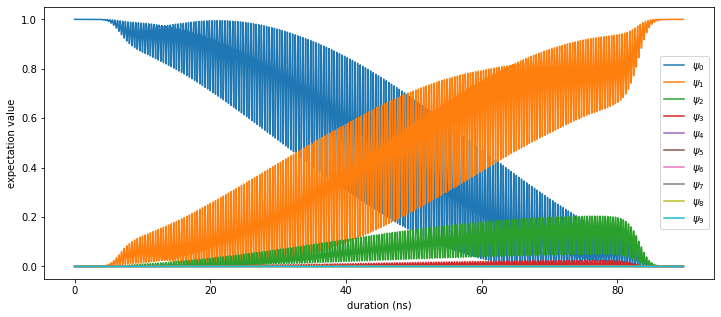

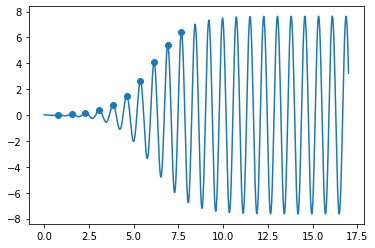

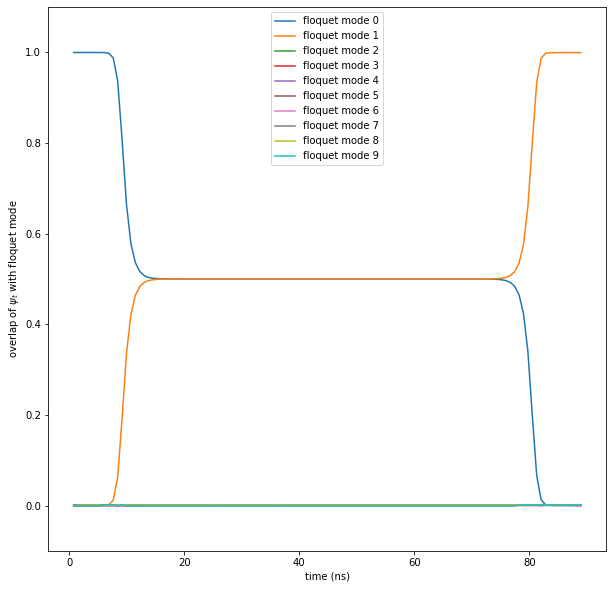

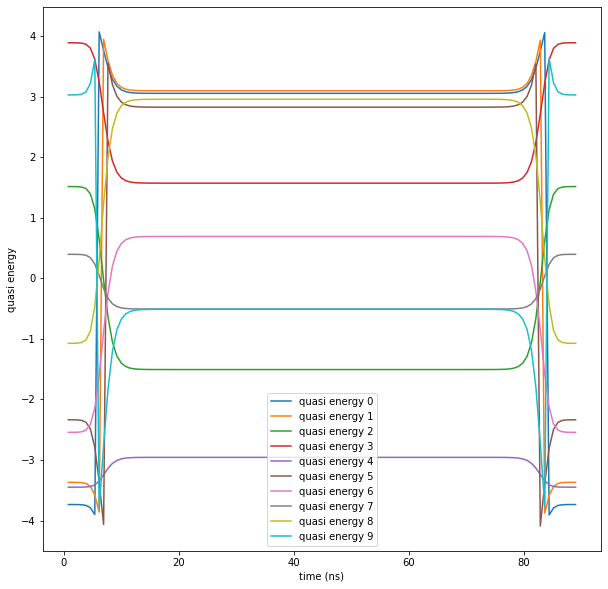

In [48]:
amp = 7.63852835090562
off = 0.12220632682501394
t_max = 89.75039347863529
freq = system.first_energy_spacing/3 - off
tlist = list(np.arange(0, t_max, (2*np.pi)/(freq*50)))
tanh.setup(amp, freq, 0.5, 3, tlist)

solution = solver.time_evolve(system.H0, system.H1, tanh.pulse_func, tlist, system.starting_state)
graph.graph_solution(solution, system)
plt.show()

floquet_results = floquetify(system, solution, tanh, tlist)

plt.figure(figsize=(10,10))
for i in range(0, len(floquet_results["expectation_values"])):
    o = floquet_results["expectation_values"][i]
    plt.plot(floquet_results["dur_points"], o, label=r'floquet mode %i' % i)
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel(r'overlap of $\psi_t$ with floquet mode')
plt.ylim((-0.1, 1.1))
plt.show()

plt.figure(figsize=(10,10))
for i in range(10):
    plt.plot(floquet_results["dur_points"], np.array(floquet_results["ordered_energies"])[:,i], label=r'quasi energy %i' % i)
plt.legend()
plt.xlabel("time (ns)")
plt.ylabel(r'quasi energy')
plt.show()

In [45]:
len(list(np.arange(0, t_max, (2*np.pi)/freq)))

118